# 01 Introduction

一种非监督机器学习方法

用于数据降维

通过降维，发现更便于人类理解的特征

其他应用：可视化、去噪

# 02 Coding实现

## 求第一主成分

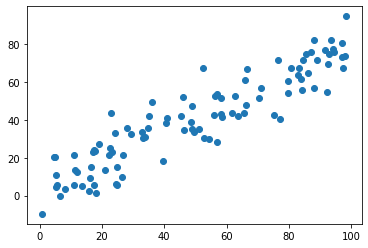

In [34]:
# 数据准备
import numpy as np
import matplotlib.pyplot as plt
X = np.empty(shape=(100, 2))
X[:, 0] = np.random.uniform(0., 100., size=100)
X[:, 1] = 0.75 * X[:, 0] + 3. + np.random.normal(0, 10., size=100)
plt.scatter(X[:,0], X[:,1])
plt.show()

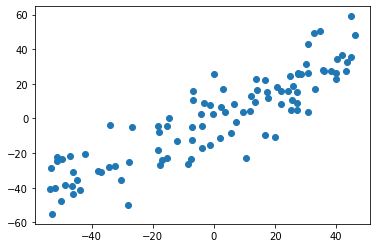

In [23]:
# demean
def demean(X):
    return X-np.mean(X, axis=0)

X_demean = demean(X)

plt.scatter(X_demean[:,0], X_demean[:, 1])
plt.show()

In [5]:
# demean结果：每个特征的平均值都约等于0
print(np.mean(X_demean[:,0]))
print(np.mean(X_demean[:,1]))

-1.8616219676914626e-14
-2.3021584638627248e-14


In [24]:
def f(w, X):
    return np.sum((X.dot(w)**2)) / len(X)

# 公式法求偏导
def df_math(w, X):
    return np.dot(X.T, X.dot(w)) *2 / len(X)

# 定义法求偏导
def df_debug(w, X, epsilon=0.0001):
    results = np.empty(len(w))
    for i in range(len(w)):
        w_left = w.copy() 
        w_left[i] -= epsilon
        w_right = w.copy()
        w_right[i] += epsilon
        results[i] = (f(w_left, X) - f(w_right, X)) / (2*epsilon)
    return results

# 将w转化为单位向量，模为1
def direation(w):
    # w / ||w||
    return w/np.linalg.norm(w)

# 梯度上升法
def gradient_ascent(df, initial_w, X, eta, n_iters=1e4, epsilon=1e-8):
    i_iters = 1
    w = direation(initial_w)
    while i_iters<=n_iters:
        last_w = w 
        gradient = df(w, X)
        w = w + eta*gradient
        w = direation(w)
        if abs(f(w, X)- f(last_w, X)) < epsilon:
            break
    return w

In [7]:
# w初始化不能为0
initial_w = np.random.random(X.shape[1])
eta = 0.01
# 不能使用StandScaler标准化数据，方差恒为1
# 而PCA的目标是求方差最大的时候w的值
w = gradient_ascent(df_math, initial_w, X_demean, eta)
w

array([0.80453489, 0.59390539])

In [8]:
# 用定义法验证一遍,偏导公式是否正确
w = gradient_ascent(df_debug, initial_w, X_demean, eta)
w

array([0.80453482, 0.59390548])

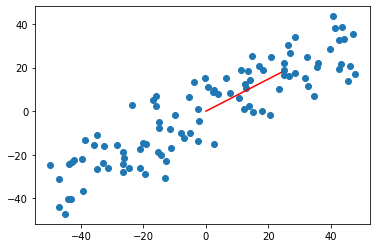

In [9]:
plt.scatter(X_demean[:,0], X_demean[:, 1])
plt.plot([0,w[0]*30], [0,w[1]*30], color='r')
plt.show()

## 求其他主成分

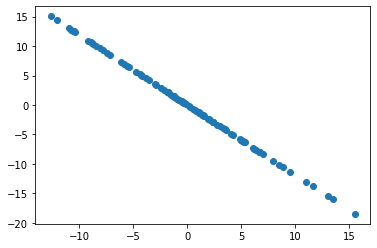

In [29]:
initial_w = np.random.random(X.shape[1])
eta = 0.01
# 求第一主成分单位向量w
w = gradient_ascent(df_math, initial_w, X_demean, eta)

# 对于X_demean中每个样本求其分量，存入X_components中
X_components = np.empty(X.shape)
for i in range(len(X_demean)):
    X_components[i] = X_demean[i] - X_demean[i].dot(w) * w
plt.scatter(X_components[:,0], X_components[:, 1])
plt.show()
#  

In [12]:
# 去处第一主成分后得分量X_components，再求主成分，其方向w如下：
w2 = gradient_ascent(df_math, initial_w, X_components, eta)
w2

array([-0.61601908,  0.78773123])

In [13]:
# w 与 w2 互相垂直
w.dot(w2)

4.623559645478004e-06

In [45]:
# 求数据集X的前n维主成分,将结果存入数据集res中
res = []
def principal_component_n(n, X, eta=0.01, n_iters=1e4, epsilon=1e-8):
    # 对X进行demean操作
    X_pca = X.copy()
    X_pca = demean(X_pca)
    for i in range(n): 
        # 每求一次主成分,初始化一次w
        initial_w = initial_w = np.random.random(X.shape[1])
        w = gradient_ascent(df_math, initial_w, X_pca, eta)
        res.append(w)
        # 减去分量
        X_pca = X_pca - X_pca.dot(w).reshape(-1,1) * w
    return res

In [48]:
r = principal_component_n(2, X)

In [50]:
np.dot(r[1], r[0])

6.623615578016384e-06

# 03 降维与升维

In [1]:
# 数据准备
import numpy as np
import matplotlib.pyplot as plt
X = np.empty(shape=(100, 2))
X[:, 0] = np.random.uniform(0., 100., size=100)
X[:, 1] = 0.75 * X[:, 0] + 3. + np.random.normal(0, 10., size=100)

In [4]:
from handjob.PCA import PCA
# 对X(2维)进行降维，结果为X_reduction
pca = PCA(n_components=1)
pca.fit(X)
X_reduction = pca.transform(X)
X_reduction.shape

(100, 1)

In [5]:
# 恢复,升维
X_restore = pca.inverse_transform(X_reduction)
X_restore.shape

(100, 2)

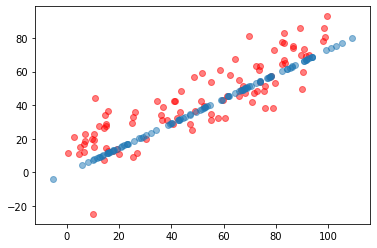

In [7]:
# 对比X和X_restore,有了一定的信息损失
# 丢失的信息无法找回
# restore的过程只是将原先低维的数据映射到高维空间上
plt.scatter(X[:,0], X[:,1], color='r', alpha=0.5)
plt.scatter(X_restore[:,0], X_restore[:,1],alpha=0.5)
plt.show()

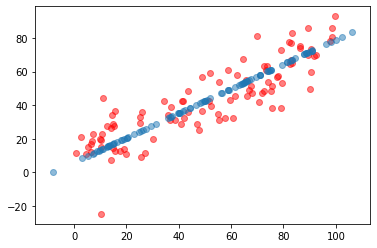

In [10]:
# 使用sklearn,求出的方向向量w与自己封装的方向相反，但并不影响降维效果
from sklearn.decomposition import PCA
pca = PCA(n_components=1)
pca.fit(X)
X_reduction = pca.transform(X)
X_restore = pca.inverse_transform(X_reduction)
plt.scatter(X[:,0], X[:,1], color='r', alpha=0.5)
plt.scatter(X_restore[:,0], X_restore[:,1],alpha=0.5)
plt.show()

## n_components的选取

降维...究竟降到几维最合适？

先来看一个实例，手写数据集，特征共有64个维度

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from sklearn import datasets

digits = datasets.load_digits()
X = digits.data
y = digits.target

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=666)

In [2]:
# 1347个样本64种特征
X_train.shape

(1347, 64)

In [3]:
%%time
# 使用所有数据进行kNN分类,准确率很高但耗时太长
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)
knn_clf.score(X_test, y_test)

Wall time: 198 ms


0.9866666666666667

如何在保证准确率不太低的情况下，合理降低特征维度，加快模型训练时间？

原数据集各个特征按重要性比例对整体数据的方差进行贡献

经过降维后选出前k个贡献最大的维度，它们合起来能保证保留原数据90%以上的方差,模型的准确率就不会太低

数据集表达的信息是由方差确定的

In [4]:
# 将原数据降到两维,查看这两个维度分别贡献了多少方差，或者说能解释多少原数据的方差
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X_train)
X_train_reduction = pca.transform(X_train)
# 这里注意，使用训练集训练好PCA模型以后，测试集也要使用这个模型进行PCA
# 而不是使用测试集重新训练一个模型
X_test_reduction = pca.transform(X_test)

# 查看当前这个只包含两个维度的模型，每个维度对原数据方差的贡献度 
pca.explained_variance_ratio_

array([0.14566817, 0.13735469])

In [5]:
# 结果显示，第一维度贡献了0.145第二维度贡献了0.137
# 合起来一共才贡献了0.28，这显然数据信息的损失太大
# 因此降维后的kNN分类模型准确率肯定不高,仅有0.6
knn_clf.fit(X_train_reduction, y_train)
knn_clf.score(X_test_reduction, y_test)

0.6066666666666667

In [7]:
# 一个包含n个特征的X，对其进行PCA，n_components最大为n
# 下面画图展示前n个维度对方差的累加总贡献

# 首先求出每个维度对方差的贡献值,这些贡献值默认按从大到小进行排列
pca_all = PCA(n_components=X.shape[1])
pca_all.fit(X_train)
X_train_all = pca.transform(X_train)
variance_ratio = pca_all.explained_variance_ratio_
variance_ratio

array([1.45668166e-01, 1.37354688e-01, 1.17777287e-01, 8.49968861e-02,
       5.86018996e-02, 5.11542945e-02, 4.26605279e-02, 3.60119663e-02,
       3.41105814e-02, 3.05407804e-02, 2.42337671e-02, 2.28700570e-02,
       1.80304649e-02, 1.79346003e-02, 1.45798298e-02, 1.42044841e-02,
       1.29961033e-02, 1.26617002e-02, 1.01728635e-02, 9.09314698e-03,
       8.85220461e-03, 7.73828332e-03, 7.60516219e-03, 7.11864860e-03,
       6.85977267e-03, 5.76411920e-03, 5.71688020e-03, 5.08255707e-03,
       4.89020776e-03, 4.34888085e-03, 3.72917505e-03, 3.57755036e-03,
       3.26989470e-03, 3.14917937e-03, 3.09269839e-03, 2.87619649e-03,
       2.50362666e-03, 2.25417403e-03, 2.20030857e-03, 1.98028746e-03,
       1.88195578e-03, 1.52769283e-03, 1.42823692e-03, 1.38003340e-03,
       1.17572392e-03, 1.07377463e-03, 9.55152460e-04, 9.00017642e-04,
       5.79162563e-04, 3.82793717e-04, 2.38328586e-04, 8.40132221e-05,
       5.60545588e-05, 5.48538930e-05, 1.08077650e-05, 4.01354717e-06,
      

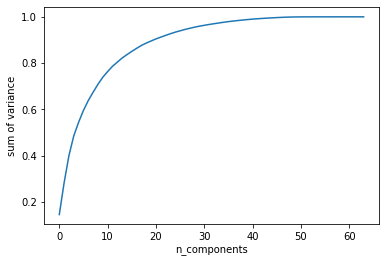

In [11]:
plt.plot(
    [i for i in range(X.shape[1])],
    [np.sum(variance_ratio[:i+1]) for i in range(X.shape[1])]
)
plt.ylabel('sum of variance')
plt.xlabel('n_components')
plt.show()

由累加贡献度图可知，当n_components取值为30左右时,这30个维度对方差的累加贡献度接近于1

因此当n_components取30左右时,既保证降低纬度加快了训练速度，又保证对kNN模型准确率的影响很小

sklearn封装了一种更简便的方法，也即在PCA模型初始化时，指定要保留原数据集方差的比例

In [20]:
pca_best = PCA(0.95)
pca_best.fit(X_train)
X_train_reduction = pca_best.transform(X_train)
X_test_reduction = pca_best.transform(X_test)
# 保留95%方差的PCA模型包含的多少维度
pca_best.n_components_

28

In [21]:
%%time
# 时间下降了6-7倍，准确度却只下降了0.006
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_reduction, y_train)
knn_clf.score(X_test_reduction, y_test)

Wall time: 29.9 ms


0.98

## 降维到2维用途

一个高纬度的数据降低到2维，丢失了很多信息，不利于模型的训练

但是降低到2维就一点用处没有吗？

一个很大的用处是可以在二维上以图表的形式表示数据

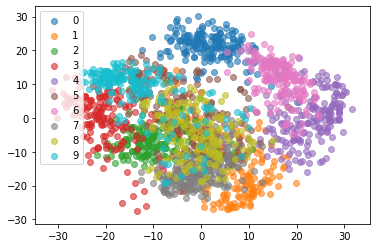

In [37]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)
X_reduction = pca.transform(X)

for num in range(10):
    
    plt.scatter(
        X_reduction[y==num, 0],
        X_reduction[y==num, 1],
        alpha=0.6,
        label=num
    )
plt.legend()
plt.show()

上图将64维手写数字表示在二维平面内，

可以看出蓝色点和橙色点区分度很大，

也即0和1很容易辨别

# 04 MNIST

In [1]:
import numpy as np
from sklearn.datasets import fetch_openml

# 使用fetch_openml远程下载sklearn提供的数据集
# MNIST是一个规模更大更正规的手写数据集
%time mnist = fetch_openml(data_id=554)

Wall time: 20.2 s


In [2]:
print(mnist.details['name'])
print(mnist.data.shape)
print(mnist.target.shape)
print(np.unique(mnist.target))
print()
print(mnist.DESCR)

mnist_784
(70000, 784)
(70000,)
['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used 

In [3]:
X, y = mnist.data, mnist.target 
X_train = np.array(X[:60000], dtype=float)
y_train = np.array(y[:60000], dtype=float)
X_test = np.array(X[60000:], dtype=float)
y_test = np.array(y[60000:], dtype=float)

In [4]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier()
%time knn_clf.fit(X_train, y_train)

Wall time: 15.7 s


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [5]:
%time knn_clf.score(X_test, y_test)

Wall time: 11min 17s


0.9688

In [7]:
%%time
# 训练时间太久，用PCA进行降维
from sklearn.decomposition import PCA
pca = PCA(0.9)
pca.fit(X_train)
X_train_reduction = pca.transform(X_train)
X_test_reduction = pca.transform(X_test)

Wall time: 3.24 s


In [8]:
X_train_reduction.shape

(60000, 87)

In [9]:
knn_clf = KNeighborsClassifier()
%time knn_clf.fit(X_train_reduction, y_train)

Wall time: 372 ms


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [10]:
%time knn_clf.score(X_test_reduction, y_test)

Wall time: 1min 8s


0.9728

不使用PCA： time = kNN_fit + score = 15.7s + 11min 17s = 11min 32.7s

PCA降维后： time = PCA_fit + kNN_fit + score = 3.24s + 0.372s + 1min 8s = 1min 12s 

而且 不仅时间降低了10倍，准确率还从0.9688提升到了0.9728，这是因为PCA实现了降噪的效果